<a href="https://colab.research.google.com/github/shaankal/NFLgamepredictor/blob/main/NFLOffenseTotals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading and Cleaning the Data

In [ ]:
import pandas as pd

offense_stats = pd.read_csv("/content/nfl_offense_ranked_teams_with_wins.csv" , index_col = 0)

offense_stats.head()

In [33]:
team_total = pd.read_csv("/content/nfl_offense_team_totals.csv" ,  index_col = 0)

team_total.head()

,rank,games,points_scored,total_yards,offensive_plays,yards_per_play,turnovers_lost,fumbles_lost,1st_downs,passes_completed,...,rushing_touchdowns,rushing_yards_per_attempt,rushing_1st_downs,penalties,penalty_yards,1st_down_penalties,percentage_scoring_drives,percentage_turnover_drives,expected_points,Week
team,,,,,,,,,,,,,,,,,,,,,
Arizona Cardinals,100,42,910,14513,2984,34.0,33,7,906,1161,...,38,30.7,320,281,2457,57,240.2,46.5,116.34,42
Atlanta Falcons,57,42,1027,13669,2455,39.3,61,30,850,590,...,54,34.3,378,186,1427,99,287.3,105.1,305.32,42
Baltimore Ravens,21,42,1138,14999,2485,43.0,49,14,847,768,...,34,38.9,378,208,1656,64,306.6,75.3,316.03,42
Buffalo Bills,26,39,1132,16811,2590,45.2,67,36,939,1034,...,22,34.3,271,228,1518,68,325.1,116.5,518.76,42
Carolina Panthers,150,42,797,11688,2292,35.4,53,21,589,706,...,29,32.0,222,226,2202,60,219.0,66.6,-228.14,42


In [12]:
offense_stats.shape


(32, 28)

In [18]:
offense_stats["rank"].value_counts()

29.5    2
25.5    2
17.5    2
1.0     1
16.0    1
31.0    1
28.0    1
27.0    1
24.0    1
23.0    1
22.0    1
21.0    1
20.0    1
19.0    1
15.0    1
2.0     1
14.0    1
13.0    1
12.0    1
11.0    1
10.0    1
9.0     1
8.0     1
7.0     1
6.0     1
5.0     1
4.0     1
3.0     1
32.0    1
Name: rank, dtype: int64

In [19]:
offense_stats.dtypes

games                           int64
points_scored                   int64
total_yards                     int64
offensive_plays                 int64
yards_per_play                float64
turnovers_lost                  int64
fumbles_lost                    int64
1st_downs                       int64
passes_completed                int64
passes_attempted                int64
passing_yards                   int64
passing_touchdowns              int64
passing_interceptions           int64
net_yards_per_pass_attempt    float64
passing_1st_downs               int64
rushing_attempts                int64
rushing_yards                   int64
rushing_touchdowns              int64
rushing_yards_per_attempt     float64
rushing_1st_downs               int64
penalties                       int64
penalty_yards                   int64
1st_down_penalties              int64
percentage_scoring_drives     float64
percentage_turnover_drives    float64
expected_points               float64
Week        

In [37]:
offense_stats["pass_rate"] = offense_stats["passes_attempted"].astype("category").cat.codes

In [38]:
offense_stats["run_rate"] = offense_stats["rushing_yards_per_attempt"].astype("category").cat.codes

In [ ]:
offense_stats

In [29]:
offense_stats["efficient_offense"] = (offense_stats["games_won"] >= 3).astype("int")

# Training/Creating the actual ML Model

In [40]:
from sklearn.ensemble import RandomForestClassifier

In [41]:
rf = RandomForestClassifier(n_estimators=50, min_samples_split=10, random_state = 1)

In [42]:
from itertools import combinations
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Assuming nfl_data is your DataFrame with the necessary columns
matchups = list(combinations(offense_stats.index, 2))
matchup_data = []

for i, j in matchups:
    team1 = offense_stats.loc[i]
    team2 = offense_stats.loc[j]
    feature_diff = {
        'games_won_diff': team1['efficient_offense'] - team2['efficient_offense'],
        'pass_rate_diff': team1['pass_rate'] - team2['pass_rate'],
        'run_rate_diff': team1['run_rate'] - team2['run_rate'],
        'winner': 1 if team1['efficient_offense'] > team2['efficient_offense'] else 0
    }
    matchup_data.append(feature_diff)

# Creating DataFrame from matchup data
matchup_df = pd.DataFrame(matchup_data)

# Splitting into features and target
X = matchup_df.drop('winner', axis=1)
y = matchup_df['winner']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Initialize and train RandomForestClassifier
rf = RandomForestClassifier(n_estimators=50, min_samples_split=10, random_state=1)
rf.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

# Visualization of ML Model

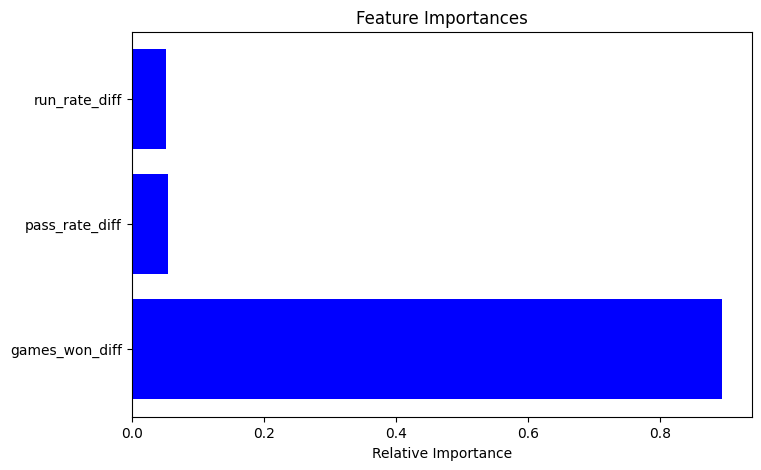

In [43]:
import matplotlib.pyplot as plt

feature_importances = rf.feature_importances_
features = X_train.columns
indices = range(len(feature_importances))

plt.figure(figsize=(8, 5))
plt.title("Feature Importances")
plt.barh(indices, feature_importances, color='b', align='center')
plt.yticks(indices, features)
plt.xlabel('Relative Importance')
plt.show()

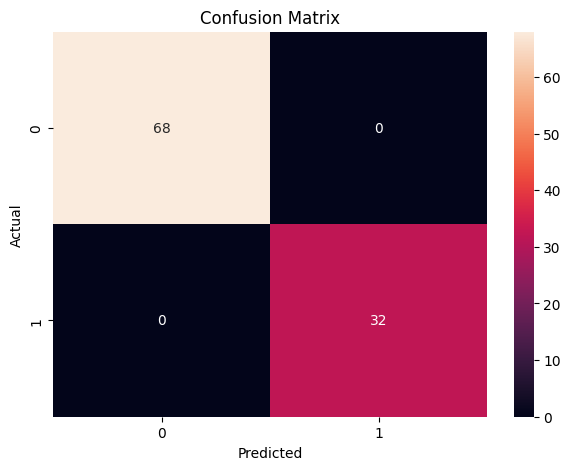

In [44]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

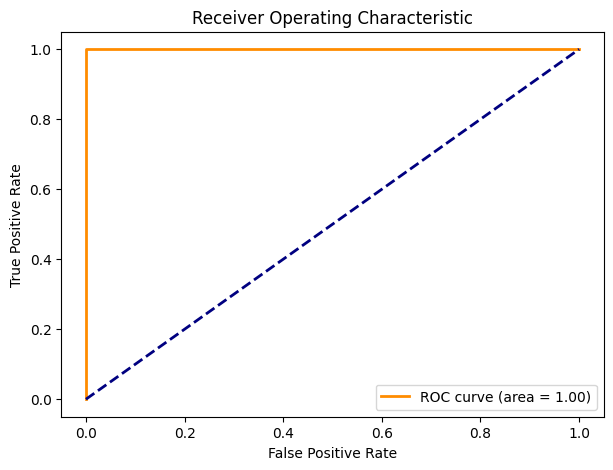

In [45]:
from sklearn.metrics import roc_curve, auc

# Calculate the ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, rf.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()